## Project Overview:
Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

In this project, we will build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. The dataset consists of 10,000 labeled tweets. I will use the LSTM technique to train an RNN model. 

# Here are the various tasks covered in this project:
- Exploratory Data Analysis
- Data Cleaning and use of pre-trained model (e.g. GloVe)
- Model Architecture
- Building a RNN model
- Model Evaluation
- Submitting result


In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
from tqdm import tqdm
import re

# nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


# sklearn
from sklearn.model_selection import train_test_split

from sklearn import model_selection, metrics, preprocessing, ensemble, model_selection, metrics

# keras and tensorflow
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from keras.optimizers import Adam

import tensorflow as tf

stop = set(stopwords.words('english'))

### Loading Data

In [3]:
df_train = pd.read_csv('../input/nlp-getting-started/train.csv')
df_test = pd.read_csv('../input/nlp-getting-started/test.csv')

### EDA

Dataset has 5 columns. Column “target” is the label column which means I am going to train a model that can predict the value of column “target” using other columns such as “text”, “location” and “keyword”.

Here are the 5 columns:

* id - a unique identifier for each tweet
* text - the text of the tweet
* location - the location the tweet was sent from (may be blank)
* keyword - a particular keyword from the tweet (may be blank)
* target - in train.csv only, this means whether a tweet is about a real disaster (1) or not (0)

In [4]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df_train.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [6]:
# shape
print(f"There are {df_train.shape[0]} rows and {df_train.shape[1]} columns. ")

There are 7613 rows and 5 columns. 


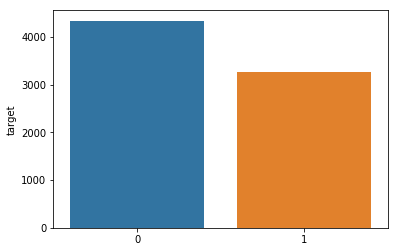

In [7]:
# Class Distribution
# 0 (Non Disaster) is more than 1 (Disaster) Tweets
class_dist = df_train.target.value_counts()
sns.barplot(class_dist.index,class_dist)

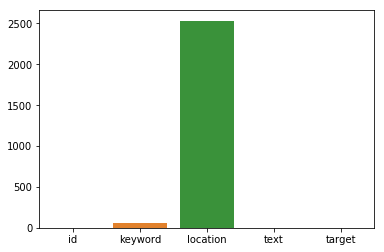

In [8]:
# Misssing vs Non Missing
# 'keyword' & 'location' columns have missing values. Lets also ignore 'keyword' and 'location' column for now.
null_vals = df_train.isnull().sum()
sns.barplot(null_vals.index,null_vals)

### Data Cleaning

Common steps for data cleaning on the NLP task dealing with tweets are removing special characters, removing stop words, removing URLs, removing numbers, and doing word stemming. 

Remove unnecessary information from the tweets.
- Remove tags
- Remove puntuctions
- Remove URL
- Remove emojis

Some NLP data preprocessing concepts:

Vectorization: Word vectorization is a technique of mapping words to a vector of real numbers. 

Tokenization: Tokenization is the task of breaking a phrase which can be anything such as a sentence, a paragraph, or just a text into smaller sections such as a series of words, a series of characters, or a series of subwords, and they are called tokens. One use of tokenization is to generate tokens from a text and later convert tokens to numbers (vectorization).

Stemming: Stemming is used to reduce extra characters from a word to its root or base of a word. For example, stemming both words “working” and “worked” becomes “work”.

Word Embedding: A word embedding is a learned representation for text where words that have the same meaning have a similar representation. Each word is mapped to one vector and the vector values are learned in a way that resembles a neural network.

Now let’s look at the entire data cleaning code:

In [9]:
# Removing <> tags

def remove_spec(text):
    text = re.sub('<.*?>+', '', text)
    text = text.lower()
    return text

# Removing puntuctions

def remove_punctuation(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

# Removing URL

def remove_urls(text):
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+",'',text)
    return text

# Removing Emojis

def remove_emoji(text):
    emojis = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = re.sub(emojis,'',text)
    return text


In [10]:
df_train['cleaned_text'] = df_train['text'].apply(lambda x : remove_punctuation(x))
df_train['cleaned_text'] = df_train['cleaned_text'].apply(lambda x : remove_urls(x))
df_train['cleaned_text'] = df_train['cleaned_text'].apply(lambda x : remove_emoji(x))
df_train['cleaned_text'] = df_train['cleaned_text'].apply(lambda x : remove_spec(x))

In [11]:
# Creating Words Corpus

def create_corpus(dataset):
    corpus = []
    for review in tqdm(dataset['cleaned_text']):
        words = [ word.lower() for word in word_tokenize(review) if (word.isalpha() == 1 ) & (word not in stop) ]
        corpus.append(words)

    return corpus

corpus = create_corpus(df_train)


100%|██████████| 7613/7613 [00:01<00:00, 7107.14it/s]


In [12]:
# Creating Embedding Dictionary

embedding_dict={}
with open('/kaggle/input/glove6b100dtxt/glove.6B.100d.txt','r', encoding='utf8') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [13]:
# Tokenize : break the sentence into single word/token
# texts_to_sequences : convert tokenized word into an encoded sequnce
# pad_sequence : change the length of sequence by either adding or truncating

MAX_LEN = 20 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

sequences = tokenizer.texts_to_sequences(corpus)

corpus_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post')

In [14]:
# Unique words present
word_index = tokenizer.word_index
print(f"Number of unique words : {len(word_index)}")

Number of unique words : 16883


In [15]:
# Creating embedding matrix with GloVe using enbedding_dict we created above
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 16883/16883 [00:00<00:00, 369380.38it/s]


## Model Architecture

LSTM (Long Short Term Memory network) is a kind of RNN (Recurrent Neural Network) that is capable of learning long-term dependencies and they can remember information for a long period of time as designed with an internal memory system.

For the LSTM model, I have started with an embedding layer to generate an embedding vector for each input sequence. Then I added a dropout layer to lower the number of features followed by a bidirectional LSTM layer. The last layer is a dense layer. Because it is a binary classification we use sigmoid as an activation function.

In [16]:
# Long Short Term Memory network.

# We need sequential model to process sequence of text data
model=Sequential()

# Embedding(input_dimension, output_dimension,embeddings_initializer = initialize the embedding matrix we created, trainable = do not train)
embedding=Embedding(num_words,100,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=MAX_LEN,
                    trainable=False)
# Adding Embedding Layer
model.add(embedding)

# Drops 40% of entire row
model.add(SpatialDropout1D(0.4))

# Recurrent Layer LSTM(dimensionality of the output space, dropout = 20%, recurrent_dropout = 20%) 
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))

# Decide what we are going to output Dense(units, activation function)
model.add(Dense(1, activation='sigmoid'))

# Compile the model compile(loss = binary crossentropy, use Adam(adaptive moment estimation) optimizer with learning rate 1e-3,evaluate based on accuracy)
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=1e-4),metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 100)           1688400   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 20, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,730,705
Trainable params: 42,305
Non-trainable params: 1,688,400
_________________________________________________________________


In [17]:
X_train,X_test,y_train,y_test = train_test_split(corpus_pad, df_train['target'].values, test_size = 0.25, random_state = 0 )

print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

print('Shape of train',y_train.shape)
print("Shape of Validation ",y_test.shape)

Shape of train (5709, 20)
Shape of Validation  (1904, 20)
Shape of train (5709,)
Shape of Validation  (1904,)


In [18]:
history=model.fit(X_train,y_train,batch_size=32,epochs=30,validation_data=(X_test,y_test),verbose=2)

Train on 5709 samples, validate on 1904 samples
Epoch 1/30
 - 3s - loss: 0.6761 - accuracy: 0.6274 - val_loss: 0.6221 - val_accuracy: 0.7532
Epoch 2/30
 - 2s - loss: 0.5695 - accuracy: 0.7332 - val_loss: 0.4966 - val_accuracy: 0.7747
Epoch 3/30
 - 2s - loss: 0.5279 - accuracy: 0.7500 - val_loss: 0.4829 - val_accuracy: 0.7831
Epoch 4/30
 - 2s - loss: 0.5290 - accuracy: 0.7462 - val_loss: 0.4750 - val_accuracy: 0.7847
Epoch 5/30
 - 2s - loss: 0.5147 - accuracy: 0.7614 - val_loss: 0.4708 - val_accuracy: 0.7920
Epoch 6/30
 - 2s - loss: 0.5062 - accuracy: 0.7653 - val_loss: 0.4678 - val_accuracy: 0.7962
Epoch 7/30
 - 2s - loss: 0.5037 - accuracy: 0.7663 - val_loss: 0.4653 - val_accuracy: 0.7941
Epoch 8/30
 - 2s - loss: 0.5010 - accuracy: 0.7698 - val_loss: 0.4654 - val_accuracy: 0.7978
Epoch 9/30
 - 2s - loss: 0.5010 - accuracy: 0.7730 - val_loss: 0.4636 - val_accuracy: 0.8004
Epoch 10/30
 - 2s - loss: 0.4949 - accuracy: 0.7705 - val_loss: 0.4621 - val_accuracy: 0.7962
Epoch 11/30
 - 2s - l

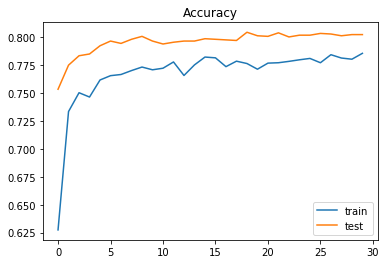

In [19]:
# Accuracy vs Epoch
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

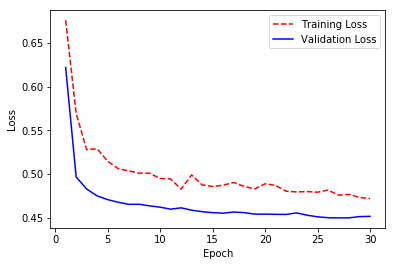

In [20]:
# Loss vs Epoch
# Visualize learning curve. It should be much smoother as it decreases.

epoch_count = range(1, len(history.history['loss']) + 1)
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

The above plot shows Learning Curve of train accuracy and loss. The plot shows as model accuracy is increasing and the loss is decreasing as expected over each epoch.

### Result

Now I have trained the model so it is time to evaluate its performance of the model. I will get the model accuracy and F-score for test data. Because the prediction value is a float between 0 and 1, I used 0.5 as a threshold to separate “0” and “1”.

In [21]:
# Clean Test data

df_test['cleaned_text'] = df_test['text'].apply(lambda x : remove_punctuation(x))
df_test['cleaned_text'] = df_test['cleaned_text'].apply(lambda x : remove_urls(x))
df_test['cleaned_text'] = df_test['cleaned_text'].apply(lambda x : remove_emoji(x))
df_test['cleaned_text'] = df_test['cleaned_text'].apply(lambda x : remove_spec(x))

In [22]:
# Creating corpus
test_corpus = create_corpus(df_test)

100%|██████████| 3263/3263 [00:00<00:00, 7035.90it/s]


In [23]:
# Encoding Test Text to Sequences
test_sequences = tokenizer.texts_to_sequences(test_corpus)

test_corpus_pad = pad_sequences(test_sequences, maxlen=MAX_LEN, truncating='post', padding='post')

In [28]:
#Evaluate the model
predictions = model.predict(X_test, verbose=1, batch_size=10000)

y_predicted = [1 if each > 0.5 else 0 for each in predictions]

score, test_accuracy = model.evaluate(X_test, y_test, batch_size=10000)

print("Test Accuracy: ", test_accuracy)
print(metrics.classification_report(list(y_test), y_predicted))

1904/1904 [==============================] - 0s 32us/step
Test Accuracy:  0.8019958138465881
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1107
           1       0.80      0.70      0.75       797

    accuracy                           0.80      1904
   macro avg       0.80      0.79      0.79      1904
weighted avg       0.80      0.80      0.80      1904



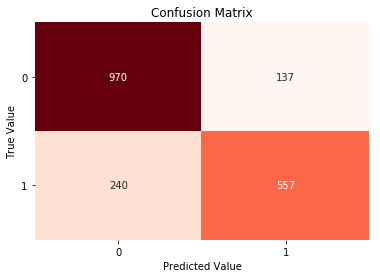

In [29]:
# Plot confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_predicted)

fig, ax = plt.subplots()
sns.heatmap(conf_matrix, cbar=False, cmap='Reds', annot=True, fmt='d')
ax.set(xlabel="Predicted Value", ylabel="True Value", title="Confusion Matrix")
ax.set_yticklabels(labels=['0', '1'], rotation=0)
plt.show()

As we can see in the Confusion matrix the model did a better job at detecting “0” than detecting “1”.

## Submission

In [30]:
# Creating submission file 
predictions = model.predict(test_corpus_pad)
predictions = np.round(predictions).astype(int).reshape(3263)
submission = pd.DataFrame({'id' : df_test['id'], 'target' : predictions})
submission.to_csv('final_submission.csv', index=False)

submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


## Github URL:
https://github.com/occoder2021/disaster-tweet-rnn